# **<center>SPARC FAIR Codeathon 2022</center>**
<center>
<a href="https://sparc.science">
<img src="https://sparc.science/_nuxt/img/logo-sparc-wave-primary.8ed83a5.svg" alt="SPARC" width="150"/>
</a>
</center>
<center>
<a href="https://sparc.science/help/2022-sparc-fair-codeathon">
<img src="https://images.ctfassets.net/6bya4tyw8399/2qgsOmFnm7wYIfRrPrqbgx/ae3255858aa12bfcebb52e95c7cacffe/codeathon-graphic.png" alt="FAIR" width="75">
</a>
</center>

## <center>Tutorial 2: Resampling data for simulations</center>


## **Introduction**
Welcome to the first of the Quilted Tutorials! We will be demonstrating different features from the [**SPARC**](https://sparc.science/) project. The goal will be to project the 2D locations of neurites in the rat stomach onto a 3D scaffhold of the organ. The data points and the 3D scaffhold will be pulled from **SPARC** datasets. Because the data is [**FAIR**](https://www.nature.com/articles/sdata201618) we will be combining three different datasets of the spatial distribution of the vagal afferents and efferents. Here is the workflow for this tutorial

![workflow](img/workflow.png)

## **Installing the dependencies**
This tutorial relies on several Python packages that have been developed as part of the **SPARC** project. We will be installing them in order to complete this tutorial.

In [1]:
!pip install pandas # To load SPARC datasets in Python
!pip install openpyxl # Pandas complement for Microsoft Excel files
!pip install ipywidgets # To interact with plotted data
# For data visualisation
!pip install numpy
!pip install numpy-stl
!pip install matplotlib
!pip install ipympl
!pip install scipy

## **Retrieving the data**
Now that all the dependencies have been installed we will retrieve the data from directly from the [**SPARC**](https://sparc.science) project website. 
We will be using three datasets:
 * [vagal afferents associated with the myenteric plexus of the rat stomach](https://sparc.science/datasets/10?type=dataset&datasetDetailsTab=files)
 * [vagal afferents within the longitudinal and circular muscle layers of the rat stomach](https://sparc.science/datasets/11?type=dataset&datasetDetailsTab=files)
 * [vagal efferents associated with the myenteric plexus of the rat stomach](https://sparc.science/datasets/12?type=dataset&datasetDetailsTab=files)
 
You can search through all of the **SPARC** datasets [here](https://sparc.science/data?type=dataset) or simply click on the links above to be redirected directly to the datasets. 

It is possible to downlowd the entire dataset by clicking on the purple ***Download full dataset*** button  in the **Download Dataset** tab or selecting specific files and folders in the **Dataset Files** tab lower in the page. If you haven't used the links above, you can click on the purple ***Get Dataset*** button on the left side of the screen or directly in the ***Files*** tab. 

For this tutorial, we are only interested in the contents of the _derative_ folder which contains two .xlsx files: one with the data (IGLE_data.xlsx, IMA_analyzed_data.xlsx, and Efferent_data.xlsx) and a manifest (manifest.xlsx). Enter the _derivative_ folder and select the xlsx file containing the data by ticking the box in front of it. Download the file by clicking the **Download Selected Files and Folders** button at the bottom. You will then be prompted to select the location in which to save it. For each dataset, save it in the _SPARC-tutorial_ folder. 

#### ⚠️  **SPARC Guru tip**: 
Ever heard of Pennsieve? It's the **SPARC** tool to use if you want to avoid downloading the data manually. It even has a Python API so you can integrate it directly into this Notebook! Check out the [documentation](https://docs.pennsieve.io/).

### **Imports**
Here we import all of the dependencies that we will need to run the code correctly.

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from stl import mesh as msh
from mpl_toolkits import mplot3d

import scipy.stats as st
from ipywidgets import interact, Checkbox, fixed

### **Helper functions**
Now that we have installed and imported the required dependencies, we are going to define some helper functions.

#### _get\_position_
This function will allow use to convert the position of the data from a percentage into a distance in mm.

In [3]:
def get_position(percent, min_val, max_val):
    """ Converts the position from percentage to distance.
    
    Inputs:
    percent -- float, percentage value.
    min_val -- float, minimum distance for conversion.
    max_val -- float, maximum distance for conversion.
    
    Outputs:
    converted_value -- float, converted value.
    
    """
    return percent / 100 * (max_val - min_val) + min_val 

#### _load\_data_
This function will allow use to extract the correct elements inside the data files and store them into a data frame.

In [4]:
def load_data(data_name, col_keeps, x_lims, y_lims):
    """ Loads the data from an .xlsx file.
    
    Inputs:
    data_name -- str, nane of the .xlsx file to read.
    col_keeps -- dict{str:str}, dictionnary containing the names of the columns
        to keep.
    x_lims -- list[int], limits for the x direction to convert back to mm,
            first element is the minimum and second is the maximum.
    y_lims -- list[int], limits for the y direction to convert back to mm,
        first element is the minimum and second is the maximum.
    
    Outputs:
    df -- DataFrame, data frame containing the desired data.
    
    """
    df = pd.read_excel(data_name)
    # remove unnecessary columns
    for col in df.columns:
        if col in col_keeps:
            df.rename(columns = {col:col_keeps[col]}, inplace = True)
        else:
            df.drop(col, axis=1, inplace=True)
    df['y'] = get_position(df['%y'], y_lims[0], y_lims[1])
    df['x'] = get_position(df['%x'], x_lims[0], x_lims[1])
    df['-%y'] = 100 - df['%y']
    # change the area to mm
    return df

#### _prepare\_data_
This function will prepare the data to be plotted. 
------ Explain here that the data is being resampled so that it can be used for sim

In [5]:
def prepare_data(df):
    """ Prepares the data to be plotted by creating the probablity estimates and the sampled points.
    
    Inputs:
    df -- 
    Outputs:
    
    """
    data_array = df
    data_array = data_array[~data_array.isin([np.nan]).any(1)]

    # Extract x and y
    x = np.array(data_array['x'])
    y = np.array(data_array['y'])

    # Create meshgrid
    xx, yy = np.mgrid[x_lims[0]:x_lims[1]:100j, y_lims[0]:y_lims[1]:100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    prob_estimate = np.reshape(kernel(positions).T, xx.shape)

    sampled_pts = kernel.resample(1000).T
    
    return xx, yy, prob_estimate, sampled_pts

### **Loading the 2D data**
In the 2D datasets that we are using, the distances are in percentages relative to an origin situated in the pyloric end of the stomach for the y-axis and near the oesophagus for the z-axis. We are going to convert those into millimeters instead. For this, we are going to define the limits in the z- and y-axis. 

Here is a 2D representation of the data we are going to map to the 3D mesh.
![2d](img/2d_data_viz.png)

In [8]:
# Setup maximimum y and z widths based on scale in image.
x_lims = [0, 36.7]
y_lims = [24.6, 0]

col_keeps = {'%x (distance from pylorus side)':'%x', '%y (distance from bottom)':'%y'}

We can now load the locations of the nerves into data frames:

In [9]:
igle_df = load_data('data/IGLE_data.xlsx', col_keeps, x_lims, y_lims)
ima_df = load_data('data/IMA_analyzed_data.xlsx', col_keeps, x_lims, y_lims)
efferent_df = load_data('data/Efferent_data.xlsx', col_keeps, x_lims, y_lims) 

### **Preparing the 2D data**
Now that we have loaded are datasets into Python, we are going to prepare to be mapped then plotted. For this, we are going to use our _convert_2D_data_ helper function. This will convert our data from the pandas DataFrame to a numpy array which will be more easy to manipulate for our objective.

In [10]:
efferent_xx, efferent_yy, efferent_est, efferent_pts = prepare_data(efferent_df)
ima_xx, ima_yy, ima_est, ima_pts = prepare_data(ima_df)
igle_xx, igle_yy, igle_est, igle_pts = prepare_data(igle_df)

### **Visualising data**
The data has now been mapped to the 3D mesh. All that is left to do is visualise the mesh and the nerves! We are going to be using the matplotlib package to visualise the data. We define a plotting function to be able to create an interactive interface. We create three checkboxes, one for each dataset, in order to visulasie the points from each data set individually. The efferents are plotted in green, the IMAs are plotted in red, and the igle are plotted in blue. You can select the data by ticking or unticking the boxes. 

#### ⚠️  **SPARC Guru tip**: 
Did you know that there are some **SPARC** tools that you can use to visualise the data? They have their own GUI that you can use. For this tutorial, we decided to keep everything in one place but they also have compatible Python APIs that will allow you to integrate the tool directly into this Notebook! Take a look [here](link to tool) to read the documentation. 

interactive(children=(IntSlider(value=1, description='selectedData', max=3, min=-1), Output()), _dom_classes=(…

Dropdown(description='Dataset:', disabled=True, options=(('Efferent', 1), ('IGLE', 2), ('IMA', 3)), value=1)

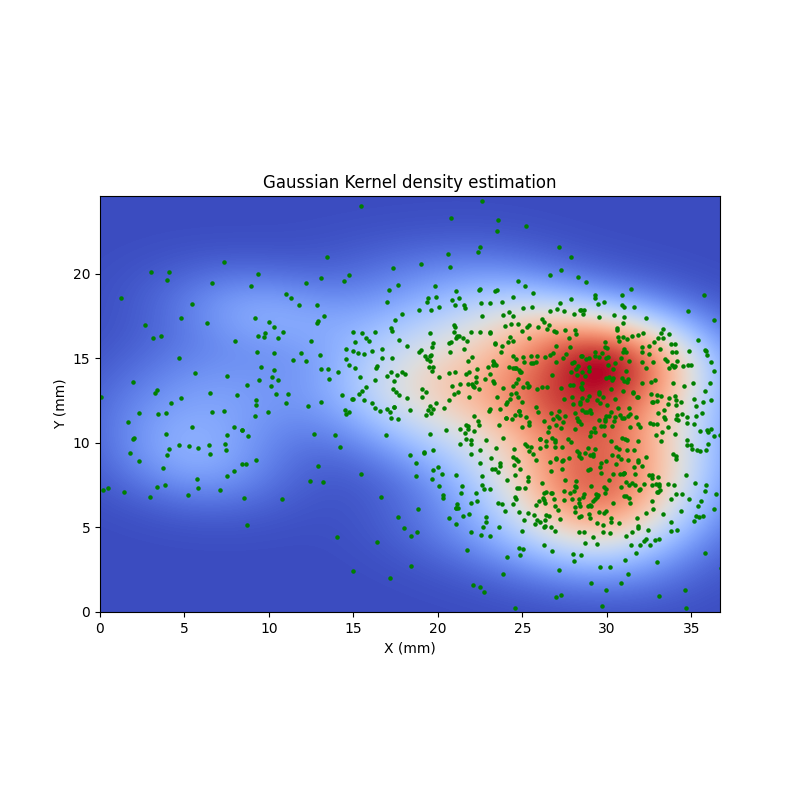

In [ ]:
# Enable interactivity in jupyterlab.
%matplotlib widget 

def plotting_fct(efferent_xx, efferent_yy, efferent_est, efferent_pts,
                 ima_xx, ima_yy, ima_est, ima_pts,
                 igle_xx, igle_yy, igle_est, igle_pts,
                 efferent, igle, ima):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()

    ax.set_xlim(x_lims[0], x_lims[1])
    ax.set_ylim(y_lims[1], y_lims[0])

    if efferent:
        cfset = ax.contourf(efferent_xx, efferent_yy, efferent_est, levels=1000,cmap='coolwarm')
        ax.imshow(np.rot90(efferent_est), cmap='coolwarm', extent=[x_lims[0], x_lims[1], y_lims[0], y_lims[1]])
        ax.scatter(efferent_pts[:, 0], efferent_pts[:, 1], s=5, color='g')

    if ima:
        cfset = ax.contourf(ima_xx, ima_yy, ima_est, levels=1000,cmap='coolwarm')
        ax.imshow(np.rot90(ima_est), cmap='coolwarm', extent=[x_lims[0], x_lims[1], y_lims[0], y_lims[1]])        
        ax.scatter(ima_pts[:, 0], ima_pts[:, 1], s=5, color='g')

    if igle:
        cfset = ax.contourf(igle_xx, igle_yy, igle_est, levels=1000,cmap='coolwarm')
        ax.imshow(np.rot90(igle_est), cmap='coolwarm', extent=[x_lims[0], x_lims[1], y_lims[0], y_lims[1]])        
        ax.scatter(igle_pts[:, 0], igle_pts[:, 1], s=5, color='g')

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    plt.title('Gaussian Kernel density estimation')


efferent=Checkbox(value=True, description="efferent")
igle=Checkbox(value=False, description="IGLE")
ima=Checkbox(value=False, description="IMA")
    

interact(plotting_fct, efferent_xx=fixed(efferent_xx), efferent_yy=fixed(efferent_yy), efferent_est=fixed(efferent_est), efferent_pts=fixed(efferent_pts), 
         ima_xx=fixed(ima_xx), ima_yy=fixed(ima_yy), ima_est=fixed(ima_est), ima_pts=fixed(ima_pts), 
         igle_xx=fixed(igle_xx), igle_yy=fixed(igle_yy), igle_est=fixed(igle_est), igle_pts=fixed(igle_pts), 
         efferent=efferent, igle=igle, ima=ima)    


### **Congratulations**
You have successfully completed your first Quilted Tutorial and are now on your way to becoming a **SPARC** Guru! 

We invite you to reuse this tutorial and explore the possibilities of using **SPARC** tools when possible. Try different things, such as adding ***your own code*** to generate a new stomach mesh with INSERT TOOL NAME. 